<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/Face_March2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics roboflow opencv-python pillow numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO

# Connect to Roboflow and download dataset
rf = Roboflow(api_key="2IGtFaicFMGaMwb2mX8A")
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(25)

# Download the dataset in YOLOv8 format
version.download("yolov8")

# Set paths
dataset_path = "./face-detection-mik1i-25"
train_yaml = os.path.join(dataset_path, "data.yaml")

# Train YOLOv8 model
def train_yolo_model(yaml_path, epochs=50, imgsz=640):
    # Initialize YOLOv8 model (can be 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt')
    model = YOLO('yolov8n.pt')  # Start with a pre-trained model

    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        patience=10,  # Early stopping patience
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        name="face_detection_model"
    )

    return model

def detect_faces(model, image_path, conf_threshold=0.25):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Run inference
    results = model(img, conf=conf_threshold)

    # Get detections
    detections = results[0]

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, confidence, class_id = detection

        # Only process if confidence is above threshold
        if confidence >= conf_threshold:
            # Draw bounding box
            cv2.rectangle(img_rgb,
                         (int(x1), int(y1)),
                         (int(x2), int(y2)),
                         (0, 255, 0), 2)

            # Add label
            label = f"Face: {confidence:.2f}"
            cv2.putText(img_rgb, label, (int(x1), int(y1) - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img_rgb, detections

# Example usage
if __name__ == "__main__":
    import torch

    # Train the model (or load a pre-trained one)
    try:
        # Try to load existing model first
        model_path = './runs/detect/face_detection_model/weights/best.pt'
        if os.path.exists(model_path):
            model = YOLO(model_path)
            print("Loaded pre-trained model from", model_path)
        else:
            print("Training new model...")
            model = train_yolo_model(train_yaml, epochs=30)
            print("Model training complete")
    except Exception as e:
        print(f"Error in model training/loading: {e}")
        exit(1)

    # Define a function to process a directory of images
    def process_directory(directory_path, output_dir='./output_images'):
        os.makedirs(output_dir, exist_ok=True)

        # Get all image files
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = [f for f in os.listdir(directory_path)
                      if os.path.isfile(os.path.join(directory_path, f)) and
                      os.path.splitext(f)[1].lower() in valid_extensions]

        print(f"Found {len(image_files)} images to process")

        for img_file in image_files:
            img_path = os.path.join(directory_path, img_file)
            try:
                print(f"Processing {img_file}...")
                img_rgb, detections = detect_faces(model, img_path)

                if img_rgb is not None:
                    # Save the output image
                    output_path = os.path.join(output_dir, f"detected_{img_file}")
                    plt.figure(figsize=(10, 8))
                    plt.imshow(img_rgb)
                    plt.axis('off')
                    plt.savefig(output_path)
                    plt.close()

                    # Count detections
                    boxes = detections.boxes
                    print(f"  Detected {len(boxes)} faces in {img_file}")
            except Exception as e:
                print(f"  Error processing {img_file}: {e}")

    # Example: Process test directory
    test_dir = os.path.join(dataset_path, "test", "images")
    process_directory(test_dir)

    # You can also process a single image
    def process_single_image(image_path):
        img_rgb, detections = detect_faces(model, image_path)
        if img_rgb is not None:
            plt.figure(figsize=(12, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"Face Detection - Found {len(detections.boxes)} faces")
            plt.show()

    # Uncomment to process a specific image
    # process_single_image("path/to/your/image.jpg")

loading Roboflow workspace...
loading Roboflow project...
Training new model...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (AMD EPYC 7B12)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./face-detection-mik1i-25/data.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=face_detection_model4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

FileNotFoundError: [Errno 2] No such file or directory: './face-detection-mik1i-25/test/images'

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
import torch

# Connect to Roboflow and download dataset
rf = Roboflow(api_key="2IGtFaicFMGaMwb2mX8A")
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(25)

# Download the dataset in YOLOv8 format
dataset = version.download("yolov8")
print("Dataset downloaded successfully")

# Get the actual local path from the dataset object
# The default path is typically './DATASET_NAME-VERSION'
# Use version.id instead of version.version_number
download_dir = f"./face-detection-mik1i-{version.id}"
print(f"Using download directory: {download_dir}")


# Find the correct paths by exploring the directory structure
def find_dataset_paths(base_dir):
    print(f"Exploring dataset structure in {base_dir}...")
    data_yaml = None
    test_images_dir = None

    # Check if base_dir exists
    if not os.path.exists(base_dir):
        print(f"Warning: Base directory {base_dir} doesn't exist!")
        return None, None

    # Look for data.yaml directly in the base directory first
    if os.path.exists(os.path.join(base_dir, "data.yaml")):
        data_yaml = os.path.join(base_dir, "data.yaml")
        print(f"Found data.yaml at: {data_yaml}")

    # Check for test/images directory
    test_dir_path = os.path.join(base_dir, "test")
    if os.path.exists(test_dir_path):
        test_images_path = os.path.join(test_dir_path, "images")
        if os.path.exists(test_images_path):
            test_images_dir = test_images_path
            print(f"Found test images at: {test_images_dir}")

    # If we didn't find test images, check for valid/images
    if not test_images_dir:
        valid_dir_path = os.path.join(base_dir, "valid")
        if os.path.exists(valid_dir_path):
            valid_images_path = os.path.join(valid_dir_path, "images")
            if os.path.exists(valid_images_path):
                test_images_dir = valid_images_path
                print(f"Found validation images at: {test_images_dir}")

    # If we still haven't found the correct paths, explore subdirectories
    if not data_yaml or not test_images_dir:
        for root, dirs, files in os.walk(base_dir):
            # Look for data.yaml if we haven't found it yet
            if not data_yaml:
                for file in files:
                    if file == "data.yaml":
                        data_yaml = os.path.join(root, file)
                        print(f"Found data.yaml at: {data_yaml}")

            # Look for test/images directory if we haven't found it yet
            if not test_images_dir:
                for directory in dirs:
                    if directory == "test" or directory == "valid":
                        test_dir = os.path.join(root, directory)
                        images_dir = os.path.join(test_dir, "images")
                        if os.path.exists(images_dir):
                            test_images_dir = images_dir
                            print(f"Found test/valid images at: {test_images_dir}")
                            break

    return data_yaml, test_images_dir

# Train YOLOv8 model
def train_yolo_model(yaml_path, epochs=50, imgsz=640):
    # Initialize YOLOv8 model (can be 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt')
    model = YOLO('yolov8n.pt')  # Start with a pre-trained model

    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        patience=10,  # Early stopping patience
        batch=16,
        device=0 if torch.cuda.is_available() else 'cpu',
        name="face_detection_model"
    )

    return model

def detect_faces(model, image_path, conf_threshold=0.25):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None

    # Run inference
    results = model(img, conf=conf_threshold)

    # Get detections
    detections = results[0]

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, confidence, class_id = detection

        # Only process if confidence is above threshold
        if confidence >= conf_threshold:
            # Draw bounding box
            cv2.rectangle(img_rgb,
                         (int(x1), int(y1)),
                         (int(x2), int(y2)),
                         (0, 255, 0), 2)

            # Add label
            label = f"Face: {confidence:.2f}"
            cv2.putText(img_rgb, label, (int(x1), int(y1) - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img_rgb, detections

# Define a function to process a directory of images
def process_directory(directory_path, model, output_dir='./output_images'):
    os.makedirs(output_dir, exist_ok=True)

    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} does not exist!")
        print("Available directories:")
        parent_dir = os.path.dirname(directory_path)
        if os.path.exists(parent_dir):
            print([d for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))])
        return

    # Get all image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [f for f in os.listdir(directory_path)
                  if os.path.isfile(os.path.join(directory_path, f)) and
                  os.path.splitext(f)[1].lower() in valid_extensions]

    if not image_files:
        print(f"No images found in {directory_path}")
        return

    print(f"Found {len(image_files)} images to process")

    for img_file in image_files:
        img_path = os.path.join(directory_path, img_file)
        try:
            print(f"Processing {img_file}...")
            img_rgb, detections = detect_faces(model, img_path)

            if img_rgb is not None and detections is not None:
                # Save the output image
                output_path = os.path.join(output_dir, f"detected_{img_file}")
                plt.figure(figsize=(10, 8))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.savefig(output_path)
                plt.close()

                # Count detections
                boxes = detections.boxes
                print(f"  Detected {len(boxes)} faces in {img_file}")
        except Exception as e:
            print(f"  Error processing {img_file}: {e}")

# Inference on a single image
def process_single_image(image_path, model):
    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} does not exist!")
        return

    img_rgb, detections = detect_faces(model, image_path)
    if img_rgb is not None and detections is not None:
        plt.figure(figsize=(12, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Face Detection - Found {len(detections.boxes)} faces")
        plt.show()

# List available directories for debugging
def list_directories(path="."):
    print(f"Contents of {path}:")
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(f"  Directory: {item}")
        else:
            print(f"  File: {item}")

# Example usage
if __name__ == "__main__":
    # Print current directory for debugging
    print("Current working directory:", os.getcwd())
    list_directories()

    # Find the correct paths in the downloaded dataset
    data_yaml, test_images_dir = find_dataset_paths(download_dir)

    if not data_yaml:
        print("Error: Could not find data.yaml file. Searching for it directly...")
        # Try to find data.yaml anywhere in current directory structure
        for root, _, files in os.walk('.'):
            for file in files:
                if file == "data.yaml":
                    data_yaml = os.path.join(root, file)
                    print(f"Found data.yaml at: {data_yaml}")
                    break
            if data_yaml:
                break

    if not data_yaml:
        print("Error: Could not find data.yaml file. Please check the dataset structure.")
        exit(1)

    # Train the model (or load a pre-trained one)
    try:
        # Try to load existing model first
        model_path = './runs/detect/face_detection_model/weights/best.pt'
        if os.path.exists(model_path):
            model = YOLO(model_path)
            print("Loaded pre-trained model from", model_path)
        else:
            print("Training new model...")
            model = train_yolo_model(data_yaml, epochs=30)
            print("Model training complete")
    except Exception as e:
        print(f"Error in model training/loading: {e}")
        exit(1)

    # Process test directory if found
    if test_images_dir:
        process_directory(test_images_dir, model)
    else:
        print("No test images directory found.")
        print("Looking for any directory containing images...")

        # Try to find any directory with images
        for root, dirs, files in os.walk(download_dir):
            image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
            if image_files:
                print(f"Found directory with images: {root}")
                process_directory(root, model)
                break

    print("\nTo test on your own images, use:")
    print("1. process_directory('/content/', model)")
    print("2. process_single_image('/content/SingleFace.jpg', model)")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded successfully
Using download directory: ./face-detection-mik1i-mohamed-traore-2ekkp/face-detection-mik1i/25
Current working directory: /content
Contents of .:
  Directory: .config
  File: SingleFace.jpg
  File: yolov8n.pt
  Directory: Face-Detection-25
  Directory: runs
  Directory: sample_data
Exploring dataset structure in ./face-detection-mik1i-mohamed-traore-2ekkp/face-detection-mik1i/25...
Error: Could not find data.yaml file. Searching for it directly...
Found data.yaml at: ./Face-Detection-25/data.yaml
Training new model...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./Face-Detection-25/data.yaml, epochs=30, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=face_detection_model2, exist_ok=False, pretrained=True, optimizer=auto, ve

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded successfully
Dataset configuration:
  names: ['face']
  nc: 1
  roboflow: {'license': 'CC BY 4.0', 'project': 'face-detection-mik1i', 'url': 'https://universe.roboflow.com/mohamed-traore-2ekkp/face-detection-mik1i/dataset/25', 'version': 25, 'workspace': 'mohamed-traore-2ekkp'}
  test: ../test/images
  train: ../train/images
  val: ../valid/images
Checking directories:
  Train: True
  Valid: True
  Test: True
Found 2 label files in: ./Face-Detection-25
  Copying README.roboflow.txt to ./Face-Detection-25/train/labels
  Copying README.dataset.txt to ./Face-Detection-25/train/labels
Found 38 label files in: ./Face-Detection-25/valid/labels
Found 38 images in: ./Face-Detection-25/valid/images
Found 4070 label files in: ./Face-Detection-25/train/labels
Found 4068 images in: ./Face-Detection-25/train/images
Found 164 label files in: ./Face-Detection-25/test/labels
Found 164 images in: ./Face-Detection-25/test/image

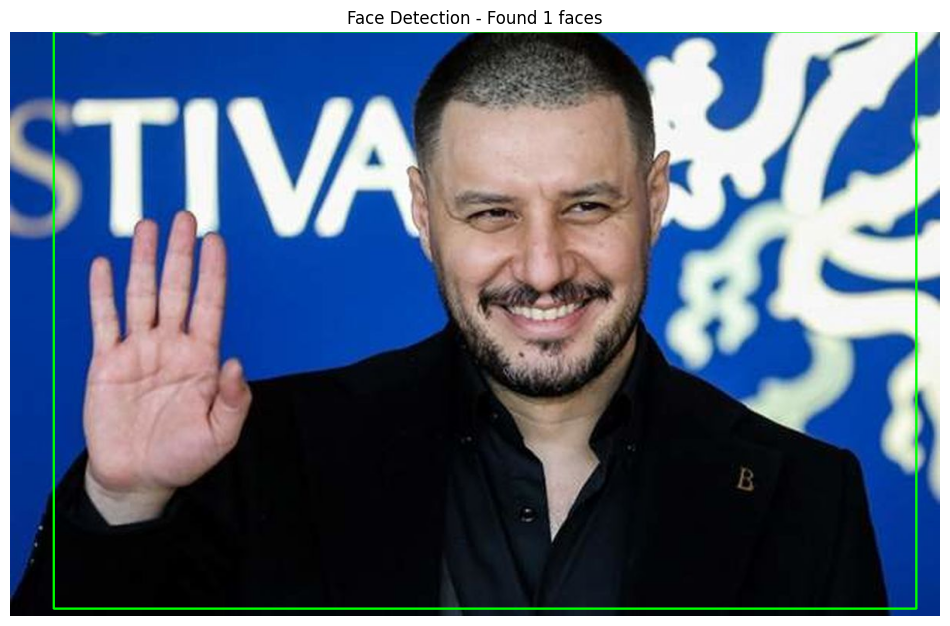

Detected 1 faces

To detect faces in your own images, use:
1. process_directory('path/to/image/folder', model)
2. process_single_image('path/to/image.jpg', model)


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
import torch
import shutil
import yaml

# Connect to Roboflow and download dataset
rf = Roboflow(api_key="2IGtFaicFMGaMwb2mX8A")
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(25)

# Download the dataset in YOLOv8 format
dataset = version.download("yolov8")
print("Dataset downloaded successfully")

# Set up the dataset properly for YOLOv8
def setup_dataset():
    # Based on the error message, we know where the actual data.yaml is
    yaml_path = "./Face-Detection-25/data.yaml"

    if not os.path.exists(yaml_path):
        print(f"Error: {yaml_path} not found")
        # Search for it
        for root, _, files in os.walk('.'):
            for file in files:
                if file == "data.yaml":
                    yaml_path = os.path.join(root, file)
                    print(f"Found data.yaml at: {yaml_path}")
                    break
            if yaml_path:
                break

    if not os.path.exists(yaml_path):
        print("Could not find data.yaml file")
        return None

    # Load the yaml file to see what's inside
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    print("Dataset configuration:")
    for key, value in data_config.items():
        print(f"  {key}: {value}")

    # Fix the paths in the data.yaml file
    base_dir = os.path.dirname(yaml_path)

    # Check if the specified directories exist
    train_dir = os.path.join(base_dir, 'train')
    valid_dir = os.path.join(base_dir, 'valid')
    test_dir = os.path.join(base_dir, 'test')

    print(f"Checking directories:")
    print(f"  Train: {os.path.exists(train_dir)}")
    print(f"  Valid: {os.path.exists(valid_dir)}")
    print(f"  Test: {os.path.exists(test_dir)}")

    # Create necessary directories if they don't exist
    if 'train' in data_config and not os.path.exists(os.path.join(base_dir, 'train', 'images')):
        os.makedirs(os.path.join(base_dir, 'train', 'images'), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'train', 'labels'), exist_ok=True)

    if 'val' in data_config and not os.path.exists(os.path.join(base_dir, 'valid', 'images')):
        os.makedirs(os.path.join(base_dir, 'valid', 'images'), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'valid', 'labels'), exist_ok=True)

    # Find and move images if they're not in the expected structure
    for root, _, files in os.walk(base_dir):
        image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        txt_files = [f for f in files if f.endswith('.txt') and f != 'data.yaml']

        if image_files:
            print(f"Found {len(image_files)} images in: {root}")

            # Determine if this is a train, valid, or test directory
            if 'train' in root.lower():
                target_dir = os.path.join(base_dir, 'train', 'images')
                label_dir = os.path.join(base_dir, 'train', 'labels')
            elif 'valid' in root.lower() or 'val' in root.lower():
                target_dir = os.path.join(base_dir, 'valid', 'images')
                label_dir = os.path.join(base_dir, 'valid', 'labels')
            elif 'test' in root.lower():
                target_dir = os.path.join(base_dir, 'test', 'images')
                label_dir = os.path.join(base_dir, 'test', 'labels')
            else:
                # If we can't determine, use 'train' as default
                target_dir = os.path.join(base_dir, 'train', 'images')
                label_dir = os.path.join(base_dir, 'train', 'labels')

            # Create directories if they don't exist
            os.makedirs(target_dir, exist_ok=True)
            os.makedirs(label_dir, exist_ok=True)

            # Move or copy images to the correct location
            for img_file in image_files:
                src_path = os.path.join(root, img_file)
                dst_path = os.path.join(target_dir, img_file)
                if not os.path.exists(dst_path):
                    print(f"  Copying {img_file} to {target_dir}")
                    shutil.copy2(src_path, dst_path)

        if txt_files:
            print(f"Found {len(txt_files)} label files in: {root}")

            # Determine if this is a train, valid, or test directory
            if 'train' in root.lower():
                label_dir = os.path.join(base_dir, 'train', 'labels')
            elif 'valid' in root.lower() or 'val' in root.lower():
                label_dir = os.path.join(base_dir, 'valid', 'labels')
            elif 'test' in root.lower():
                label_dir = os.path.join(base_dir, 'test', 'labels')
            else:
                # If we can't determine, use 'train' as default
                label_dir = os.path.join(base_dir, 'train', 'labels')

            # Create directory if it doesn't exist
            os.makedirs(label_dir, exist_ok=True)

            # Move or copy label files to the correct location
            for txt_file in txt_files:
                src_path = os.path.join(root, txt_file)
                dst_path = os.path.join(label_dir, txt_file)
                if not os.path.exists(dst_path) and txt_file != 'data.yaml':
                    print(f"  Copying {txt_file} to {label_dir}")
                    shutil.copy2(src_path, dst_path)

    # Update data.yaml with correct paths
    data_config['path'] = base_dir

    # Make sure train and val paths are correctly set
    if 'train' in data_config:
        data_config['train'] = os.path.join('train', 'images')
    if 'val' in data_config:
        data_config['val'] = os.path.join('valid', 'images')

    # Write updated yaml
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f)

    print(f"Updated dataset configuration file at {yaml_path}")
    return yaml_path

# Train YOLOv8 model
def train_yolo_model(yaml_path, epochs=30, imgsz=640):
    # Initialize YOLOv8 model
    model = YOLO('yolov8n.pt')  # Start with a pre-trained model

    # Train the model
    try:
        results = model.train(
            data=yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            patience=10,  # Early stopping patience
            batch=16,
            device=0 if torch.cuda.is_available() else 'cpu',
            name="face_detection_model"
        )
        return model
    except Exception as e:
        print(f"Training error: {e}")
        return None

def detect_faces(model, image_path, conf_threshold=0.25):
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None

    # Run inference
    results = model(img, conf=conf_threshold)

    # Get detections
    detections = results[0]

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, confidence, class_id = detection

        # Only process if confidence is above threshold
        if confidence >= conf_threshold:
            # Draw bounding box
            cv2.rectangle(img_rgb,
                         (int(x1), int(y1)),
                         (int(x2), int(y2)),
                         (0, 255, 0), 2)

            # Add label
            label = f"Face: {confidence:.2f}"
            cv2.putText(img_rgb, label, (int(x1), int(y1) - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img_rgb, detections

# Define a function to process a directory of images
def process_directory(directory_path, model, output_dir='./output_images'):
    os.makedirs(output_dir, exist_ok=True)

    # Check if directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} does not exist!")
        return

    # Get all image files
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [f for f in os.listdir(directory_path)
                  if os.path.isfile(os.path.join(directory_path, f)) and
                  os.path.splitext(f)[1].lower() in valid_extensions]

    if not image_files:
        print(f"No images found in {directory_path}")
        return

    print(f"Found {len(image_files)} images to process")

    for img_file in image_files:
        img_path = os.path.join(directory_path, img_file)
        try:
            print(f"Processing {img_file}...")
            img_rgb, detections = detect_faces(model, img_path)

            if img_rgb is not None and detections is not None:
                # Save the output image
                output_path = os.path.join(output_dir, f"detected_{img_file}")
                plt.figure(figsize=(10, 8))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.savefig(output_path)
                plt.close()

                # Count detections
                boxes = detections.boxes
                print(f"  Detected {len(boxes)} faces in {img_file}")
        except Exception as e:
            print(f"  Error processing {img_file}: {e}")

# Inference on a single image
def process_single_image(image_path, model, conf_threshold=0.25):
    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} does not exist!")
        return

    img_rgb, detections = detect_faces(model, image_path, conf_threshold)
    if img_rgb is not None and detections is not None:
        plt.figure(figsize=(12, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(f"Face Detection - Found {len(detections.boxes)} faces")
        plt.savefig('detected_single_face.jpg')
        plt.show()
        print(f"Detected {len(detections.boxes)} faces")
        return img_rgb, detections

# Download a pretrained face detection model if available
def get_pretrained_model():
    try:
        # Try using a pretrained YOLOv8 face detection model from Ultralytics
        model = YOLO('yolov8n-face.pt')
        print("Loaded pretrained face detection model")
        return model
    except Exception:
        print("No pretrained face detection model found, will need to train one")
        return None

# Example usage
if __name__ == "__main__":
    # Set up the dataset for training
    yaml_path = setup_dataset()

    # Try to get a pretrained model first
    model = get_pretrained_model()

    if model is None:
        # If no pretrained model, try to load or train one
        try:
            model_path = './runs/detect/face_detection_model/weights/best.pt'
            if os.path.exists(model_path):
                model = YOLO(model_path)
                print("Loaded previously trained model from", model_path)
            elif yaml_path:
                print("Training new model...")
                model = train_yolo_model(yaml_path)
                if model is None:
                    print("Training failed. Using base YOLOv8 model instead.")
                    model = YOLO('yolov8n.pt')  # Fallback to base model
            else:
                print("No dataset configuration found. Using base YOLOv8 model.")
                model = YOLO('yolov8n.pt')  # Fallback to base model
        except Exception as e:
            print(f"Error in model setup: {e}")
            print("Using base YOLOv8 model as fallback.")
            model = YOLO('yolov8n.pt')  # Fallback to base model

    # Check if we have a sample image to test
    single_face_path = "SingleFace.jpg"
    if os.path.exists(single_face_path):
        print(f"\nProcessing sample image {single_face_path}")
        process_single_image(single_face_path, model)
    else:
        print(f"Sample image {single_face_path} not found")

        # Look for any image files in the current directory
        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
        image_files = [f for f in os.listdir('.')
                      if os.path.isfile(f) and
                      os.path.splitext(f)[1].lower() in valid_extensions]

        if image_files:
            print(f"Found {len(image_files)} images in current directory")
            for img_file in image_files[:1]:  # Process just the first image
                print(f"\nProcessing found image {img_file}")
                process_single_image(img_file, model)

    print("\nTo detect faces in your own images, use:")
    print("1. process_directory('path/to/image/folder', model)")
    print("2. process_single_image('path/to/image.jpg', model)")